In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt
import os
import cv2
import time
import copy
import shutil 
import zipfile
from torchvision import transforms, models
from tqdm import tqdm
from PIL import Image
# from google.colab import files

In [2]:
# Let's define some variables
class_names = ['cleaned', 'dirty']
train_dir = 'train'
valid_dir = 'valid'
test_dir = 'test'

# Extract images (Kaggle enviropment)
data_root = r'G:\My Drive\Colab Notebooks\plates\Kaggle-Cleaned-vs-Dirty-\'

In [3]:
class MyRemoveBackground:
    """Remove images background.
    """
    
    def __init__(self):
        pass

    def __call__(self, in_img):
        
        # Convert PIL image to numpy array
        in_img = np.array(in_img)
        
        # Get the height and width from OpenCV image
        height, width = in_img.shape[:2]
        
        # Create a mask holder
        mask = np.zeros([height, width], np.uint8)

        # Grab Cut the object
        bgdModel = np.zeros((1, 65),np.float64)
        fgdModel = np.zeros((1, 65),np.float64)

        # Hard Coding the Rect The object must lie within this rect.
        rect = (15, 15, width-30, height-30)
        cv2.grabCut(in_img, mask, rect, bgdModel, fgdModel, 10, cv2.GC_INIT_WITH_RECT)
        mask = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')
        out_img = in_img * mask[:, :, np.newaxis]

        # Get the background
        background = in_img - out_img

        # Change all pixels in the background that are not black to white
        background[np.where((background > [0, 0, 0]).all(axis = 2))] = [255, 255, 255]

        #Add the background and the image
        out_img = background + out_img

        return transforms.functional.to_pil_image(out_img)
    

class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [4]:
def unzip_data(zip_file, destination_dir):
    """Extract pictures from zip file.
    """
    print('Data extraction started...', end='')
    with zipfile.ZipFile(zip_file, 'r') as zip_obj:
        zip_obj.extractall(destination_dir)
    print('done.')
    print(f'Files unzipped to \'{destination_dir}\'\n')

def make_train_valid_data():
    """Split train pictures to train and valid groups.
    """
    
    print('Copy pictures to Train and Valid groups started...', end='')
    for dir_name in [train_dir, valid_dir]:
        for class_name in class_names:
            os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

    for class_name in class_names:
        src_dir = os.path.join(data_root, 'train', class_name)
        files = os.listdir(src_dir)
        files = list(filter(lambda x: x.endswith('.jpg'), files))
        
        for i, file_name in enumerate(files):
            if i % 6 != 0:
                dst_dir = os.path.join(train_dir, class_name) 
            else:
                dst_dir = os.path.join(valid_dir, class_name)
#             shutil.copy(os.path.join(src_dir, file_name), os.path.join(dst_dir, file_name))
                shutil.move(os.path.join(src_dir, file_name), os.path.join(dst_dir, file_name))
    print('done.')
    
    
def remove_background(image_roots):
    """Remove picture background.
       This function use MyRemoveBackground class.
    """
    remove_photo_background = MyRemoveBackground()

    print('Backgrounds removing started...')
    for path in image_roots:
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg'), files))
        
        print(f'{len(files)} pictures was found in {path}', end='')
        for i, file in enumerate(files):
            img_original = cv2.imread(path + file)
            img_cleaned = remove_photo_background(img_original)
            img_cleaned = np.array(img_cleaned)
            cv2.imwrite(path + file, img_cleaned)
            if i % 20 == 0:
                print('\n{:>3d}/{:>3d}'.format(i, len(files)), end='')
            print('.', end='')
        print()
    print('Backgrounds removing is complete.\n')
    
def make_extra_images(image_roots):
    """Function will make extra pictures with horizontal and vertical reflection.
    """

    print('Extra pictures generation started...', end='')
    prefix_names = ['_090', '_180', '_270']

    for path in image_roots:
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg') and '_' not in x, files))

        for i, file in enumerate(files):
            img = cv2.imread(path + file)
            # Make extra pictures: flip each of originals photo to 90, 180 and 270 degrees
            for i, angle in enumerate([cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_180, cv2.ROTATE_90_COUNTERCLOCKWISE]):
                img = cv2.rotate(img, angle)
                img_name = path + file[:file.find('.')] + prefix_names[i] + file[file.find('.'):]
                if not os.path.exists(img_name):
                    cv2.imwrite(img_name, img)
    print('done.')

    for path in image_roots:
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg'), files))
        print(f'{len(files)} pictures added to \'{path}\'')
    print()
    
    # Generate mini report
    for dir_name in [train_dir, valid_dir]:
        for class_name in class_names:
            dst_dir = os.path.join(dir_name, class_name)
            files = os.listdir(dst_dir)
            files = list(filter(lambda x: x.endswith('.jpg'), files))
            print(f'{len(files)} pictures copied to \'{dst_dir}\'')
    print()
    

def make_test_data():
    """Copy test pictures to test group.
    """  

    print('Copy pictures to Test group started...', end='')
    src_dir = os.path.join(data_root, 'test')
    dst_dir = os.path.join(test_dir, 'unknown')
    shutil.copytree(src_dir, dst_dir)
    files = os.listdir(dst_dir)
    files = list(filter(lambda x: x.endswith('.jpg'), files))
    print('done.')
    print(f'{len(files)} pictures copied to \'{dst_dir}\'\n')

In [34]:
unzip_data(zip_file='G:\My Drive\Colab Notebooks\plates\plates.zip', destination_dir='G:\My Drive\Colab Notebooks\plates\Kaggle-Cleaned-vs-Dirty-')


Data extraction started...done.
Files unzipped to 'G:\My Drive\Colab Notebooks'



In [35]:
# Remove images background 
remove_background(image_roots=[os.path.join(data_root, train_dir, 'cleaned/'),
                               os.path.join(data_root, train_dir, 'dirty/')
#                                ,os.path.join(data_root, 'test/')
                              ])

# Create extra images for training models
make_extra_images(image_roots=[os.path.join(data_root, train_dir, 'cleaned/'),
                               os.path.join(data_root, train_dir, 'dirty/')])

# Copy images to train, valid and test dir

Backgrounds removing started...
20 pictures was found in G:\My Drive\Colab Notebooks\plates\train\cleaned/
  0/ 20....................
20 pictures was found in G:\My Drive\Colab Notebooks\plates\train\dirty/
  0/ 20....................
Backgrounds removing is complete.

Extra pictures generation started...done.
80 pictures added to 'G:\My Drive\Colab Notebooks\plates\train\cleaned/'
80 pictures added to 'G:\My Drive\Colab Notebooks\plates\train\dirty/'



## Make additional photo of trainin data by transforming existing

In [8]:
def make_grayscale(image_roots):
    prefix_names = ['_grayscale']
    for path in image_roots:
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg') and '_' not in x, files))
        for i, file in enumerate(files):
            image = Image.open(path + file)
            image = image.convert('1')
            img_name = path + file[:file.find('.')] + prefix_names[0] + file[file.find('.'):]
            if not os.path.exists(img_name):
                image.save(img_name)
    for path in image_roots:
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg'), files))
        print(f'{len(files)} pictures added to \'{path}\'')
    print()

In [44]:
make_grayscale(image_roots=[os.path.join(data_root, train_dir, 'cleaned/'),
                               os.path.join(data_root, train_dir, 'dirty/')])

100 pictures added to 'G:\My Drive\Colab Notebooks\plates\train\cleaned/'
100 pictures added to 'G:\My Drive\Colab Notebooks\plates\train\dirty/'



In [45]:
def make_noise(image_roots):
    print('Extra pictures generation started...', end='')
    prefix_names = ['_noise']
    mean = 0
    var = 10
    sigma = var ** 0.5
    for path in image_roots:
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg') and '_' not in x, files))
        for i, file in enumerate(files):
            image = cv2.imread(path + file)
            gaussian = np.uint8(np.random.normal(mean, sigma, image.shape))
            noisy_image = cv2.add(image,gaussian)
            img_name = path + file[:file.find('.')] + prefix_names[0] + file[file.find('.'):]
            if not os.path.exists(img_name):
                cv2.imwrite(img_name, noisy_image) 
    print('done.')

    for path in image_roots:
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg'), files))
        print(f'{len(files)} pictures added to \'{path}\'')
    print()

In [46]:
make_noise(image_roots=[os.path.join(data_root, train_dir, 'cleaned/'),
                               os.path.join(data_root, train_dir, 'dirty/')])

Extra pictures generation started...done.
120 pictures added to 'G:\My Drive\Colab Notebooks\plates\train\cleaned/'
120 pictures added to 'G:\My Drive\Colab Notebooks\plates\train\dirty/'



In [47]:
def make_shapes(image_roots):
    """Function will make extra pictures with horizontal and vertical reflection.
    """
    print('Extra pictures generation started...', end='')
    prefix_names = ['_shape']

    for path in image_roots:
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg') and '_' not in x, files))
        
        for i, file in enumerate(files):
            image = cv2.imread(path + file)
            # Make extra pictures: flip each of originals photo to 90, 180 and 270 degrees
              # просто цифры 0, 1, 2
            hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            green_low = np.array([45 , 100, 50] )
            green_high = np.array([75, 255, 255])
            curr_mask = cv2.inRange(hsv_img, green_low, green_high)
            hsv_img[curr_mask > 0] = ([75,255,200])
            RGB_again = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
            gray = cv2.cvtColor(RGB_again, cv2.COLOR_RGB2GRAY)
            ret, threshold = cv2.threshold(gray, 90, 255, 0)
            contours, hierarchy =  cv2.findContours(threshold,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(image, contours, -1, (0, 0, 255), 3)

            img_name = path + file[:file.find('.')] + prefix_names[0] + file[file.find('.'):]
            if not os.path.exists(img_name):
                cv2.imwrite(img_name, image) 
    print('done.')

    for path in image_roots:
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg'), files))
        print(f'{len(files)} pictures added to \'{path}\'')
    print()

In [48]:
# Create extra images for training models
make_shapes(image_roots=[os.path.join(data_root, train_dir, 'cleaned/'),
                               os.path.join(data_root, train_dir, 'dirty/')])

Extra pictures generation started...done.
140 pictures added to 'G:\My Drive\Colab Notebooks\plates\train\cleaned/'
140 pictures added to 'G:\My Drive\Colab Notebooks\plates\train\dirty/'



In [5]:
# Transformations methods
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5, interpolation=3, fill=255),
        transforms.RandomChoice([transforms.CenterCrop(180),
                                 transforms.CenterCrop(160),
                                 transforms.CenterCrop(140),
                                 transforms.CenterCrop(120),
                                 transforms.Compose([transforms.CenterCrop(280),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 transforms.Compose([transforms.CenterCrop(200),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 ]),
        transforms.Resize((224, 224)),
        transforms.ColorJitter(hue=(0.1, 0.2)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5, interpolation=3, fill=255),
        transforms.RandomChoice([transforms.CenterCrop(180),
                                 transforms.CenterCrop(160),
                                 transforms.CenterCrop(140),
                                 transforms.CenterCrop(120),
                                 transforms.Compose([transforms.CenterCrop(280),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 transforms.Compose([transforms.CenterCrop(200),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 ]),
        transforms.Resize((224, 224)),
        transforms.ColorJitter(hue=(0.1, 0.2)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),}


C:\ProgramData\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:768: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [95]:
# Datasets
dataset = {
    'train': torchvision.datasets.ImageFolder(root=data_root + '\\train', transform=image_transforms['train']),
    'valid': torchvision.datasets.ImageFolder(root=data_root + '\\valid', transform=image_transforms['valid']),
    'test': torchvision.datasets.ImageFolder(root=data_root + '\\test',transform=None),
}
 
# Dataloaders
batch_size = 6
train_dataloader = torch.utils.data.DataLoader(dataset['train'],
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=batch_size)

valid_dataloader = torch.utils.data.DataLoader(dataset['valid'],
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=batch_size)

test_dataloader  = torch.utils.data.DataLoader(dataset['test'],
                                               batch_size=1,
                                               shuffle=False,
                                               num_workers=0)

# Mini report of loaded data
print('Train, Valid and Test datasets are loaded:\n')
print('{:<7s}{:>10s}{:>10s}'.format('Dataset', 'Batches', 'Pictures')), print('-' * 28)
print('{:<7s}{:>10d}{:>10d}'.format('Train', len(train_dataloader), len(dataset['train'])))
print('{:<7s}{:>10d}{:>10d}'.format('Valid', len(valid_dataloader), len(dataset['valid'])))
print('{:<7s}{:>10d}{:>10d}'.format('Test',  len(test_dataloader),  len(dataset['test'])))

Train, Valid and Test datasets are loaded:

Dataset   Batches  Pictures
----------------------------
Train          39       232
Valid           8        48
Test          744       744


In [8]:
def dec_block(in_f, out_f,activation='sigmoid'):
    activations = torch.nn.ModuleDict([
                ['lrelu', torch.nn.LeakyReLU()],
                ['relu', torch.nn.ReLU()],
                ['sigmoid',torch.nn.Sigmoid()]
    ])
    return torch.nn.Sequential(
        torch.nn.Linear(in_f, out_f),
        activations[activation],
    )

In [62]:
class MyResNet18(torch.nn.Module):
    def __init__(self,dec_sizes,activation,n_classes=2):
        super(MyResNet18, self).__init__()
        self.net = models.resnet18(pretrained=True)
        
        # Disable grad for all conv layers
        for param in self.net.parameters():
            param.requires_grad = False                
        
        # Create some additional layers for ResNet model
        fc_inputs = self.net.fc.in_features
        dec_sizes.insert(0, fc_inputs)
        self.net.fc = torch.nn.Sequential(*[dec_block(in_f, out_f,activation) 
                       for in_f, out_f in zip(dec_sizes, dec_sizes[1:])],
                                         torch.nn.Linear(dec_sizes[-1], n_classes))  
    def forward(self, x):
        x = self.net(x)
        return x

class MyResNet50(torch.nn.Module):
    def __init__(self,dec_sizes,activation,n_classes=2):
        super(MyResNet50, self).__init__()
        self.net = models.resnet50(pretrained=True)
        
        # Disable grad for all conv layers
        for param in self.net.parameters():
            param.requires_grad = False                
        
        # Create some additional layers for ResNet model
        fc_inputs = self.net.fc.in_features
        dec_sizes.insert(0, fc_inputs)
        self.net.fc = torch.nn.Sequential(*[dec_block(in_f, out_f,activation) 
                       for in_f, out_f in zip(dec_sizes, dec_sizes[1:])],
                                         torch.nn.Linear(dec_sizes[-1], n_classes))
    def forward(self, x):
        x = self.net(x)
        return x

    
class MyResNet152(torch.nn.Module):
    def __init__(self,dec_sizes,activation,n_classes=2):
        super(MyResNet152, self).__init__()
        self.net = models.resnet152(pretrained=True)
        
        # Disable grad for all conv layers
        for param in self.net.parameters():
            param.requires_grad = False                
        
        # Create some additional layers for ResNet model
        fc_inputs = self.net.fc.in_features
        dec_sizes.insert(0, fc_inputs)
        self.net.fc = torch.nn.Sequential(*[dec_block(in_f, out_f,activation) 
                       for in_f, out_f in zip(dec_sizes, dec_sizes[1:])],
                                         torch.nn.Linear(dec_sizes[-1], n_classes))  
    def forward(self, x):
        x = self.net(x)
        return x
    

class MyMobilenet(torch.nn.Module):
    def __init__(self):
        super(MyMobilenet, self).__init__()
        self.net = models.mobilenet_v2(pretrained=True)
        
        # Disable grad for all conv layers
        for param in self.net.parameters():
            param.requires_grad = False                
        
        # Create some additional layers for ResNet model
        fc_inputs = self.net.classifier[1].in_features
        self.net.classifier[1] = torch.nn.Sequential(
            torch.nn.Linear(fc_inputs, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 2),
        )  
    def forward(self, x):
        x = self.net(x)
        return x    


class MyAlexNet(torch.nn.Module):
    def __init__(self):
        super(MyAlexNet, self).__init__()
        self.net = models.alexnet(pretrained=True)
        
        # Disable grad for all conv layers
        for param in self.net.parameters():
            param.requires_grad = False                
        
        # Create some additional layers for ResNet model
        fc_inputs = self.net.classifier[6].in_features
        self.net.classifier[6] = torch.nn.Sequential(
            torch.nn.Linear(fc_inputs, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 2),
        )  
    def forward(self, x):
        x = self.net(x)
        return x  

In [66]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loss_hist = {'train':[], 'valid':[]}
    accuracy_hist = {'train':[0.5], 'valid':[0.5]}
    
    print('{:<7s}|{:^20s}|{:^20s}|'.format('', 'Train', 'Valid'))
    print('{:<7s}|{:>10s}{:>10s}|{:>10s}{:>10s}|'.format('Epoch', 'Loss', 'Acc', 'Loss', 'Acc'))
    print('-' * 50)
    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = valid_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss_value.item()
                # Running_acc += (preds_class == labels.data).float().mean()
                running_acc += (preds_class == labels.data).float().mean().data.cpu().numpy()                

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            if phase == 'train':
                print('{:>3d}/{:>3d}|{:>10.4f}{:>10.4f}|'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc), end='')
            else:
                try:
                    if epoch_acc>max(accuracy_hist[phase]):
                        torch.save(model, data_root + '\\best-model_new'+ model.__class__.__name__ + '.pt')
                        print('{:>10.4f}{:>10.4f}|{}'.format(epoch_loss, epoch_acc,'Best model seved'))
                    else:
                        print('{:>10.4f}{:>10.4f}|'.format(epoch_loss, epoch_acc))
                except:
                    pass
            loss_hist[phase].append(epoch_loss)
            accuracy_hist[phase].append(epoch_acc)

    return model, loss_hist, accuracy_hist

In [13]:
def train_MyModel(model, epoch_num):
    print('\n' + model.__class__.__name__ + ' training with {} epochs started...\n'.format(epoch_num))
 
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1.0e-3)

    # Decay LR by a factor of 0.1 every 7 epochs
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    model, losses, accuracies = train_model(model, loss, optimizer, scheduler, num_epochs=epoch_num);
    print('\nModel training finished.')    
    
    return model, losses, accuracies

In [14]:
device = torch.device("cpu")

In [93]:
list_models = [MyResNet18([256],'relu'),MyResNet50([256],'relu'),MyResNet152([256],'relu'),MyMobilenet(),MyAlexNet()]

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-

In [96]:
result_data = []
for model in list_models:
    model = model
    model, losses, accuracies = train_MyModel(model, epoch_num=40)
    model.eval()
    result_data.append([model.__class__.__name__, losses, accuracies])


MyResNet18 training with 40 epochs started...

       |       Train        |       Valid        |
Epoch  |      Loss       Acc|      Loss       Acc|
--------------------------------------------------
  1/ 40|    0.6171    0.7115|    0.3917    0.8333|Best model seved
  2/ 40|    0.5262    0.7692|    0.4074    0.8125|
  3/ 40|    0.4482    0.7650|    0.4158    0.7708|
  4/ 40|    0.4831    0.7821|    0.3473    0.8542|Best model seved
  5/ 40|    0.5338    0.7308|    0.3176    0.8750|Best model seved
  6/ 40|    0.4842    0.7265|    0.3117    0.8333|
  7/ 40|    0.4133    0.8098|    0.2992    0.8542|
  8/ 40|    0.3809    0.8333|    0.2557    0.9375|Best model seved
  9/ 40|    0.4080    0.7949|    0.4034    0.8333|
 10/ 40|    0.3957    0.8141|    0.3222    0.8750|
 11/ 40|    0.3871    0.8291|    0.3641    0.8333|
 12/ 40|    0.3928    0.8077|    0.3106    0.8333|
 13/ 40|    0.3988    0.8226|    0.3858    0.8333|
 14/ 40|    0.3453    0.8568|    0.2652    0.9375|
 15/ 40|    0.3828   

In [82]:
dt=pd.DataFrame()
data = pd.DataFrame()
for name in range(5):
    for j,loss_acc in enumerate(['Loss','Accuracy']):
        for phase in losses.keys():
            dt[str(loss_acc)+'_'+str(phase)] = result_data[name][j+1][phase][j:]
            dt['Model_name'] = result_data[name][0]
    data = pd.concat([data,dt],ignore_index=True)

## Create transformation for test data

In [100]:
transform_image = {
    'to_tensor_and_normalize': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# List of transformation methods
transforms_list = { 
    'original': transforms.Compose([
        transforms.Resize((224, 224)),
    ]),   
    'crop_220': transforms.Compose([
        transforms.CenterCrop(220),
        transforms.Resize((224, 224)),
    ]), 
    'crop_200': transforms.Compose([
        transforms.CenterCrop(200),
        transforms.Resize((224, 224)),
    ]),    
    'crop_180': transforms.Compose([
        transforms.CenterCrop(180),
        transforms.Resize((224, 224)),
    ]),    
    'crop_160': transforms.Compose([
        transforms.CenterCrop(160),
        transforms.Resize((224, 224)),
    ]),   
    'crop_140': transforms.Compose([
        transforms.CenterCrop(140),
        transforms.Resize((224, 224)),
    ]),   
    'crop_120': transforms.Compose([
        transforms.CenterCrop(120),
        transforms.Resize((224, 224)),
    ]),    
    'gray_280': transforms.Compose([
        transforms.Grayscale(3),
        transforms.CenterCrop(280),
        transforms.Resize((224, 224)),
    ]),
    'gray_200': transforms.Compose([
        transforms.Grayscale(3),
        transforms.CenterCrop(200),
        transforms.Resize((224, 224)),
    ]),
    'r_crop_180_1': transforms.Compose([
        transforms.RandomCrop(180),
        transforms.Resize((224, 224)),
    ]),
    'r_crop_180_2': transforms.Compose([
        transforms.RandomCrop(180),
        transforms.Resize((224, 224)),
    ]),
    'r_crop_180_3': transforms.Compose([
        transforms.Grayscale(3),
        transforms.RandomCrop(180),
        transforms.Resize((224, 224)),
    ]),        
}

# Test Dataset
dataset['test'] = ImageFolderWithPaths(data_root + '\\test\\', transform=None)

# Test Dataloaders
test_dataloader  = torch.utils.data.DataLoader(dataset['test'],
                                               batch_size=1,
                                               shuffle=False,
                                               num_workers=0)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [42]:
remove_background(image_roots=[os.path.join(data_root, r'Kaggle-Cleaned-vs-Dirty-\\test\Unknown\\')])

Backgrounds removing started...
744 pictures was found in G:\My Drive\Colab Notebooks\plates\test\Unknown\\
  0/744....................
 20/744....................
 40/744....................
 60/744....................
 80/744....................
100/744....................
120/744....................
140/744....................
160/744....................
180/744....................
200/744....................
220/744....................
240/744....................
260/744....................
280/744....................
300/744....................
320/744....................
340/744....................
360/744....................
380/744....................
400/744....................
420/744....................
440/744....................
460/744....................
480/744....................
500/744....................
520/744....................
540/744....................
560/744....................
580/744....................
600/744....................
620/744.................

## Print predictions for single photo with all transformation applied

N  Method         Percent
-------------------------
1  original        0.2713
2  crop_220        0.7893
3  crop_200        0.9157
4  crop_180        0.9747
5  crop_160        0.9441
6  crop_140        0.9650
7  crop_120        0.9397
8  gray_280        0.7253
9  gray_200        0.9797
10 r_crop_180_1    0.3650
11 r_crop_180_2    0.8896
12 r_crop_180_3    0.8273
-------------------------


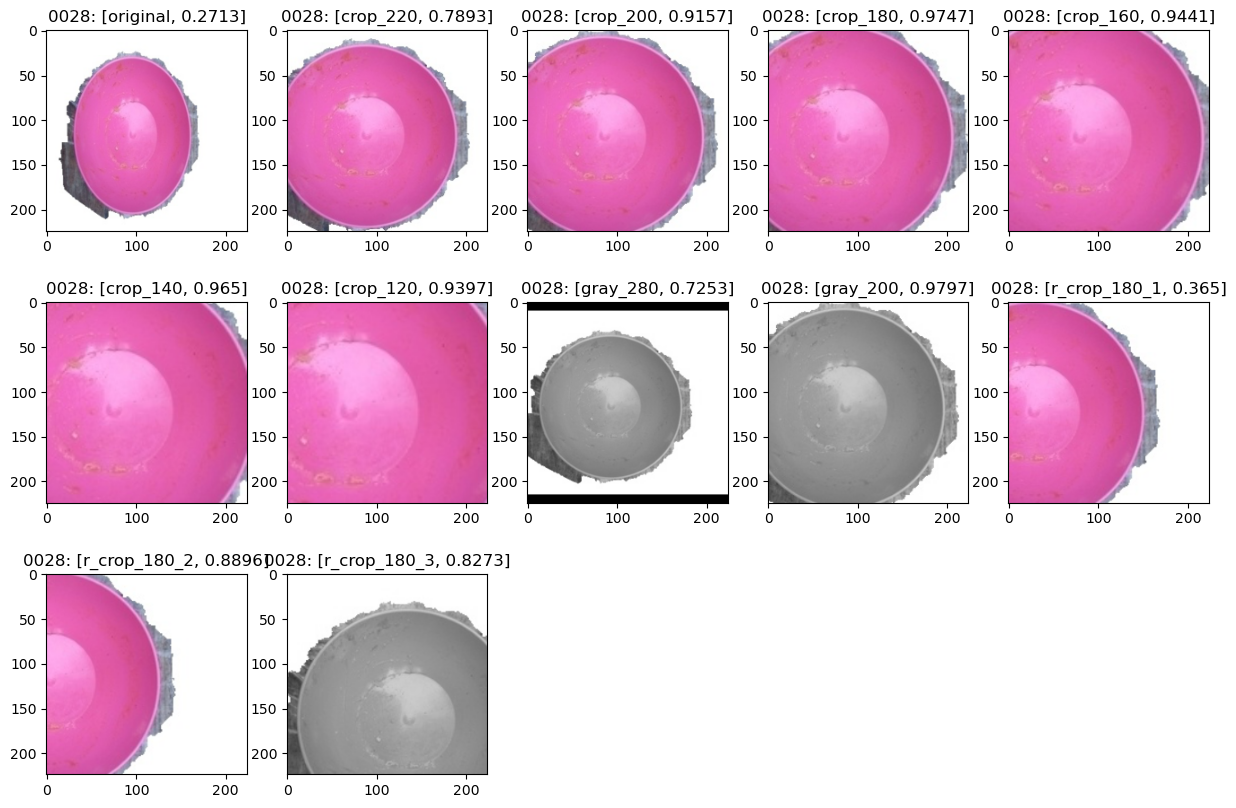

In [101]:
model = torch.load(data_root+'\\' + [f for f in os.listdir(data_root) if 'newMy' in f][0])
    
img_id = 28

img_original = test_dataloader.dataset[img_id][0]

img_id = test_dataloader.dataset[img_id][2]
img_id = img_id.replace('G:\\My Drive\\Colab Notebooks\\plates\\Kaggle-Cleaned-vs-Dirty-\\test\\Unknown\\', '')
img_id = img_id.replace('.jpg', '')

labels = {}
labels['id'] = img_id

# Make prediction for each method in tranformation_list
for i, method in enumerate(transforms_list):
    img_transformed = transforms_list[method](img_original)
    tensor = transform_image['to_tensor_and_normalize'](img_transformed)
    tensor = tensor.to(device)
    tensor = tensor.unsqueeze(0)

    with torch.set_grad_enabled(False):
        preds = model(tensor)
        
    label = torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy()[0]
    labels[method] = label

# Vizualization 
plt.rcParams['figure.figsize'] = (15, 10)
for i, method in enumerate(transforms_list):
    img_transformed = transforms_list[method](img_original)
    plt.subplot(3, 5, i + 1)
    plt.title(img_id +': ['+ method + ', ' + str(round(labels[method],4))+']')
    plt.imshow(img_transformed); 

# Print prediction's results    
print('{:3s}{:15s}{:7s}'.format('N', 'Method', 'Percent')), print('-' * 25)
for i, method in enumerate([x for x in labels if x != 'id']):
    print('{:<3d}{:<15s}{:>7.4f}'.format(i+1, method, labels[method]))
print('-' * 25)

## Make predicions for all data and all transformation

In [102]:
data = []
for model_trained in [f for f in os.listdir(data_root) if 'newMy' in f]:
    model = torch.load(data_root+'\\' + model_trained)
    for img_original, labels, img_id in tqdm(test_dataloader.dataset):
        labels = {}
        img_id = img_id.replace('G:\\My Drive\\Colab Notebooks\\plates\\test\\Unknown\\', '')
        img_id = img_id.replace('.jpg', '')
        labels['id'] = img_id
        labels['Model_name'] = model.__class__.__name__

        for i, method in enumerate(transforms_list):
            img_transformed = transforms_list[method](img_original)
            tensor = transform_image['to_tensor_and_normalize'](img_transformed)
            tensor = tensor.to(device)
            tensor = tensor.unsqueeze(0)

            with torch.set_grad_enabled(False):
                preds = model(tensor)

            label = torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy()[0]
            labels[method] = label

        data.append(labels)
    data_2 = pd.DataFrame(data)

100%|████████████████████████████████████████████████████████████████████████████████| 744/744 [07:32<00:00,  1.64it/s]


In [103]:
data_2.to_csv('All_predictions.csv',sep=';',index=False, encoding = 'CP1251')

In [104]:
data_2['Mean'] = data_2[[col for col in data_2.columns if 'Model_name' not in col]].mean(axis=1)
data_2 = data_2.reset_index()
df_2 = pd.pivot_table(data=data_2[['id','Model_name','Mean']], index = ['id'], columns = ['Model_name'], values = ['Mean'])
df_2.columns = ["_".join(tup) for tup in df_2.columns.to_flat_index() if 'id' not in tup]
df_2.reset_index(inplace=True)
df_2['Mean'] = df_2[[col for col in df_2.columns if 'id' not in col]].mean(axis=1)
df_2['label'] = df_2['Mean'].map(lambda x: 'cleaned' if x <= 0.5 else 'dirty')

C:\Users\tyure\AppData\Local\Temp\ipykernel_8316\204738500.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data_2['Mean'] = data_2[[col for col in data_2.columns if 'Model_name' not in col]].mean(axis=1)


In [105]:
# Remove extra columns
df_2.drop(df_2.columns[1:-1], axis='columns', inplace=True)
df_2.head()
df_2['label'].value_counts()

dirty      505
cleaned    239
Name: label, dtype: int64

In [106]:
df_2.to_csv('submission_all_models.csv',index=False)